In [2]:
import os
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Input  
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy



In [3]:
color_to_label = {
    (180, 180, 180): 0,  # Gris - Végétation clairsemée
    (0, 100, 0): 1,     # Vert - Couverture arborée
    (255, 187, 34): 2,  # Orange - Broussailles
    (255, 255, 76): 3,  # Jaune - Prairie
    (240, 150, 255): 4, # Rose - Terre cultivée
    (250, 0, 0): 5,     # Rouge - Zones urbanisées
    (240, 240, 240): 6, # Blanc - Neige et glace
    (0, 100, 200): 7,   # Bleu - Plans d'eau permanents
    (0, 150, 160): 8,   # Vert-bleu - Marais herbacé
    (0, 207, 117): 9,   # Vert mangrove - Mangroves
    (250, 230, 160): 10, # Mousse - Lichens
    (0, 0, 0): 11       # Noir - Sans données
}

In [4]:
def label_to_class(label_img):
    # Convertir en RGB si nécessaire
    label_img = label_img.convert('RGB')
    label_array = np.array(label_img)
    height, width = label_array.shape[:2]
    class_map = np.zeros((height, width), dtype=int)

    for y in range(height):
        for x in range(width):
            pixel = tuple(label_array[y, x])
            class_idx = color_to_label.get(pixel, 11)  # Utilisez -1 ou un autre numéro pour les couleurs non mappées
            class_map[y, x] = class_idx

    return class_map


def load_images_and_masks(satellite_folder, mask_folder):
    satellite_images = []
    masks = []
    for filename in os.listdir(satellite_folder):
        sat_img = Image.open(os.path.join(satellite_folder, filename))
        mask_img = Image.open(os.path.join(mask_folder, filename))  # Assurez-vous que les noms correspondent

        satellite_images.append(np.array(sat_img))
        masks.append(label_to_class(mask_img))

    return np.array(satellite_images), np.array(masks)



In [5]:
path_satellite_images = 'TrainData\Esa_tile2_Sat'  # Chemin vers les images satellites
path_labelled_images = 'TrainData\Esa_tile2_resize'  # Chemin vers les images labelisées (masques)

X, Y = load_images_and_masks(path_satellite_images, path_labelled_images)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [6]:

def EncoderMiniBlock(inputs, n_filters=12, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=12):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

def create_unet_model(input_shape, num_classes,n_filters=32):
    inputs = Input(input_shape)
    
  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(num_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Remplacer par la forme réelle de vos images et le nombre de canaux (par exemple, (1440, 1440, 3) pour des images RGB)
model = create_unet_model((1440, 1440, 3), num_classes=12)
model.compile(optimizer='adam', 
              loss=SparseCategoricalCrossentropy(from_logits=True),  # Assuming softmax activation in the last layer
              metrics=['accuracy'])



In [7]:
model = load_model('testmodelv5.h5')
model.fit(X_train, Y_train, batch_size=8, epochs=2, validation_data=(X_test, Y_test))
model.evaluate(X_test, Y_test)

Epoch 1/2
30/30 [==============================] - 29582s 1008s/step - loss: 0.8925 - accuracy: 0.6876 - val_loss: 0.8688 - val_accuracy: 0.6885
Epoch 2/2
2/2 [==============================] - 795s 338s/step - loss: 0.8611 - accuracy: 0.6953


[0.8611394166946411, 0.6953252553939819]

In [8]:

label_to_color = {v: k for k, v in color_to_label.items()}

# Charger et prétraiter l'image
def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size) # Assurez-vous que target_size correspond à la taille d'entrée du modèle
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) # Ajouter une dimension pour le batch
    return image

def prediction_to_image(prediction):
    # Prendre l'indice de la classe la plus probable
    prediction = np.argmax(prediction, axis=-1)

    # Initialiser une image RGB vide
    colored_prediction = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

    # Appliquer la couleur à chaque pixel
    for label, color in label_to_color.items():
        colored_prediction[prediction == label] = color

    return Image.fromarray(colored_prediction)

# Faire une prédiction et afficher avec Pillow
def predict_and_display(model, image_path, target_size=(1440, 1440)):
    image = load_and_preprocess_image(image_path, target_size)
    prediction = model.predict(image)[0] # Récupérer la prédiction pour le premier élément du batch

    # Convertir la prédiction en image PIL et afficher
    original_image = Image.open(image_path)
    predicted_image = prediction_to_image(prediction)

    original_image.show(title='Image Originale')
    predicted_image.show(title='Prédiction du Modèle')

# Exemple d'utilisation
image_path = 'TrainData/Esa_tile2_Sat/ESA_WorldCover_10m_2021_V200_N36E027_Map.tif' # Remplacer par le chemin de votre image
predict_and_display(model, image_path)

1/1 [==============================] - 8s 8s/step


In [9]:
model.save("testmodelv6.h5")

2/2 [==============================] - 910s 383s/step


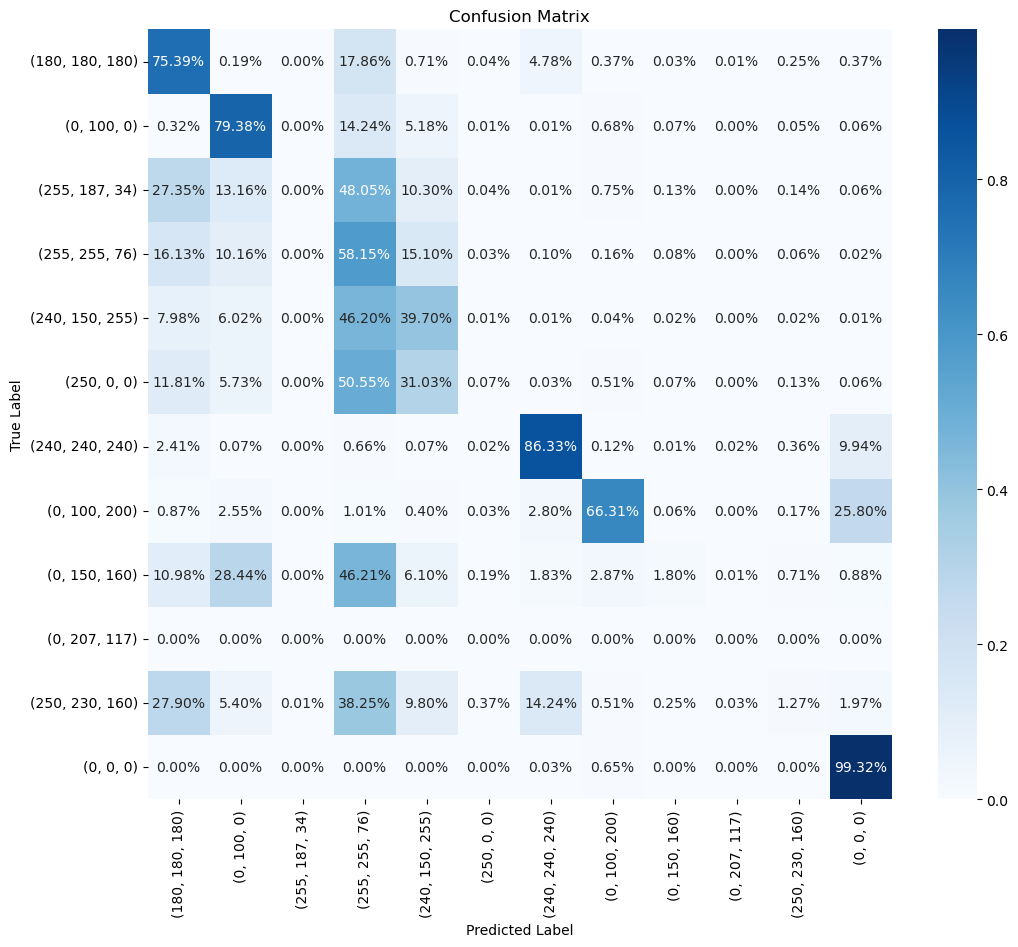

C:\Users\adrie\.conda\envs\env_ia\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adrie\.conda\envs\env_ia\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

(180, 180, 180)       0.56      0.75      0.64  10189863
    (0, 100, 0)       0.82      0.79      0.81  26147982
 (255, 187, 34)       0.01      0.00      0.00    373897
 (255, 255, 76)       0.49      0.58      0.53  24699224
(240, 150, 255)       0.53      0.40      0.45  15950662
    (250, 0, 0)       0.02      0.00      0.00    991482
(240, 240, 240)       0.59      0.86      0.70   1859106
  (0, 100, 200)       0.96      0.66      0.78  16567487
  (0, 150, 160)       0.31      0.02      0.03   1377780
  (0, 207, 117)       0.00      0.00      0.00         0
(250, 230, 160)       0.08      0.01      0.02    715797
      (0, 0, 0)       0.84      0.99      0.91  23469120

       accuracy                           0.70 122342400
      macro avg       0.43      0.42      0.41 122342400
   weighted avg       0.69      0.70      0.68 122342400



C:\Users\adrie\.conda\envs\env_ia\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:


# Make predictions on the test data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=3)

# Flatten the ground truth and predicted labels for confusion matrix calculation
flat_true_labels = Y_test.flatten()
flat_pred_labels = predicted_labels.flatten()


# Calculate confusion matrix
conf_mat = confusion_matrix(flat_true_labels, flat_pred_labels, normalize='true')  # normalize='all' for overall normalization

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt=".2%", cmap='Blues', xticklabels=color_to_label.keys(), yticklabels=color_to_label.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
class_names = [str(label) for label in color_to_label.keys()]
print(classification_report(flat_true_labels, flat_pred_labels, target_names=class_names))
